# Authorship Similarity Detection

In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import pandas as pd
import numpy as np

#Graphics
import seaborn as sns
import matplotlib.pyplot as plt

#Preprocessing 
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
nltk.download('punkt')
from nltk import SnowballStemmer

#ML
import sklearn
from sklearn import metrics as mt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import MaxAbsScaler
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import  RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier 


#Utils
import os
import string
from collections import Counter
import joblib
import pickle
from itertools import compress


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rbnra\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rbnra\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
def RandomizedSearch_table_plot(grid_clf, param_list=[],
                          num_results=40,
                          negative=True,
                          graph=True,
                          display_all_params=True):

  
    from matplotlib      import pyplot as plt
    from IPython.display import display
    import pandas as pd

    clf = grid_clf.best_estimator_
    clf_params = grid_clf.best_params_
    if negative:
        clf_score = -grid_clf.best_score_
    else:
        clf_score = grid_clf.best_score_
    clf_stdev = grid_clf.cv_results_['std_test_score'][grid_clf.best_index_]
    cv_results = grid_clf.cv_results_

    print("best parameters: {}".format(clf_params))
    print("best score:      {:0.5f} (+/-{:0.5f})".format(clf_score, clf_stdev))
    #if display_all_params:
     #   import pprint
      #  pprint.pprint(clf.get_params())

    # pick out the best results
    # =========================
    scores_df = pd.DataFrame(cv_results).sort_values(by='rank_test_score')
    import uuid
      
    scores_df.to_pickle(str(uuid.uuid4())+"file.pkl")
    best_row = scores_df.iloc[0, :]
    if negative:
        best_mean = -best_row['mean_test_score']
    else:
        best_mean = best_row['mean_test_score']
    best_stdev = best_row['std_test_score']
    #best_param = best_row['param_' + param_name]

    # display the top 'num_results' results
    # =====================================
    table=pd.DataFrame(cv_results)
    del table['split0_test_score']
    del table['split1_test_score']
    del table['split2_test_score']
    del table['split3_test_score']
    del table['split4_test_score']
    del table['split0_train_score']
    del table['split1_train_score']
    del table['split2_train_score']
    del table['split3_train_score']
    del table['split4_train_score']
    del table['mean_fit_time']
    del table['std_fit_time']
    del table['mean_score_time']	
    del table['std_score_time']
    del table['params']
    display(table \
            .sort_values(by='rank_test_score').head(num_results))

    # plot the results
    # ================
    scores_df = scores_df.sort_values(by='rank_test_score')
    #print(scores_df.keys())
    for param_name in param_list:
        scores_df = scores_df.sort_values(by='param_' + param_name)
        best_param = best_row['param_' + param_name]
        
        if negative:
            means = -scores_df['mean_test_score']
        else:
            means = scores_df['mean_test_score']
        stds = scores_df['std_test_score']
        params = scores_df['param_' + param_name]
        params.fillna(1400, inplace=True)
        #params = [str(i) for i in params]
        # plot
        if graph:
            plt.figure(figsize=(4, 4))
            plt.plot(params, means,"o")

            plt.axhline(y=best_mean + best_stdev, color='red')
            plt.axhline(y=best_mean - best_stdev, color='red')
            plt.plot(best_param, best_mean, 'or')

            plt.title(param_name + " vs Score\nBest Score {:0.5f}".format(clf_score))
            plt.xlabel(param_name)
            plt.ylabel('Score')
    plt.show()
  
#Selection of the best number of components for TruncatedSVD
def select_n_components(var_ratio, goal_var: float) -> int:
    total_variance = 0.0

    n_components = 0
    
    for explained_variance in var_ratio:
    
        total_variance += explained_variance
        
        n_components += 1
        
        if total_variance >= goal_var:
            break
            
    return n_components


def show_results(labels, predictions):
    print( "Accuracy: ", accuracy_score(labels, predictions))
    print("Avg Precision", precision_score(labels, predictions, average='weighted')) 
    print("Avg Recall",recall_score(labels, predictions, average='weighted')) 
    print("Avg F1-score",f1_score(labels, predictions, average='weighted')) 


#Function that displays histogram between models based on accuracy
def plot_glob_accuracy(model_names,list_accuracy):
    if(len(model_names) == 2):
        y_pos = np.arange(1,3)
        colors = ("teal","mediumturquoise")
        plt.figure(figsize=(8,5))
        plt.xticks(y_pos,model_names,fontsize=14)
        plt.yticks(np.arange(0.00, 1.01, step=0.1))
        plt.ylim(0,1)
        plt.ylabel('Accuracy')
        plt.bar(y_pos,list_accuracy,color=colors)
        plt.grid()
        plt.show()
    else:
        y_pos = np.arange(1,4)
        colors = ("teal","mediumturquoise","mediumaquamarine")
        plt.figure(figsize=(15,5))
        plt.xticks(y_pos,model_names,fontsize=14)
        plt.yticks(np.arange(0.00, 1.01, step=0.1))
        plt.ylim(0,1)
        plt.ylabel('Accuracy')
        plt.bar(y_pos,list_accuracy,color=colors)
        plt.grid()
        plt.show()

             
def plot_glob_f1score(model_names,list_f1score):
    if(len(model_names) == 2):
        y_pos = np.arange(1,3)
        colors = ("purple","darkorchid")
        plt.figure(figsize=(8,5))
        plt.xticks(y_pos,model_names,fontsize=14)
        plt.yticks(np.arange(0.00, 1.01, step=0.1))
        plt.ylim(0,1)
        plt.ylabel('F1 score')
        plt.bar(y_pos,list_f1score,color=colors)
        plt.grid()
        plt.show()
    else:
        y_pos = np.arange(1,4)
        colors = ("purple","darkorchid", "orchid")
        plt.figure(figsize=(15,5))
        plt.xticks(y_pos,model_names,fontsize=14)
        plt.yticks(np.arange(0.00, 1.01, step=0.1))
        plt.ylim(0,1)
        plt.ylabel('F1 score')
        plt.bar(y_pos,list_f1score,color=colors)
        plt.grid()
        plt.show()

# Dataset loading and structure analysis

In [150]:
dataset = pd.read_csv("../Data/writing_style_dataset.csv", sep = '*')
import itertools
replacements = dict(zip(dataset['author'].unique(),itertools.count(1)))
dataset["author"] = dataset["author"].replace(replacements)

In [151]:
dataset.head()

,text,author
0,According to Vance s response to Lauri s email...,1
1,Effective 3 1 2001 HPLC amended its contract w...,2
2,Louis Cox with Copano the interconnecting part...,3
3,X cc Weissman George O ENRON OU NA CN RECIPIEN...,4
4,I m still concern about April s nom if we don ...,4


In [152]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 638 entries, 0 to 637
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    638 non-null    object
 1   author  638 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 10.1+ KB


In [153]:
authors_list = list(dict.fromkeys(dataset['author'].values))
print("Total number of authors:", len(authors_list))

Numero totale di autori: 97


Counter({30: 260, 40: 45, 8: 44, 16: 18, 2: 13, 1: 12, 37: 12, 5: 11, 31: 9, 86: 8, 7: 7, 13: 7, 18: 7, 41: 6, 60: 6, 28: 5, 36: 5, 42: 5, 73: 5, 81: 5, 6: 4, 17: 4, 22: 4, 39: 4, 54: 4, 61: 4, 80: 4, 87: 4, 88: 4, 96: 4, 3: 3, 10: 3, 15: 3, 27: 3, 32: 3, 43: 3, 56: 3, 59: 3, 67: 3, 69: 3, 76: 3, 82: 3, 95: 3, 4: 2, 9: 2, 19: 2, 21: 2, 23: 2, 33: 2, 34: 2, 46: 2, 64: 2, 72: 2, 79: 2, 84: 2, 85: 2, 89: 2, 90: 2, 11: 1, 12: 1, 14: 1, 20: 1, 24: 1, 25: 1, 26: 1, 29: 1, 35: 1, 38: 1, 44: 1, 45: 1, 47: 1, 48: 1, 49: 1, 50: 1, 51: 1, 52: 1, 53: 1, 55: 1, 57: 1, 58: 1, 62: 1, 63: 1, 65: 1, 66: 1, 68: 1, 70: 1, 71: 1, 74: 1, 75: 1, 77: 1, 78: 1, 83: 1, 91: 1, 92: 1, 93: 1, 94: 1, 97: 1})


Text(0.5, 1.0, 'Distribuition of classes')

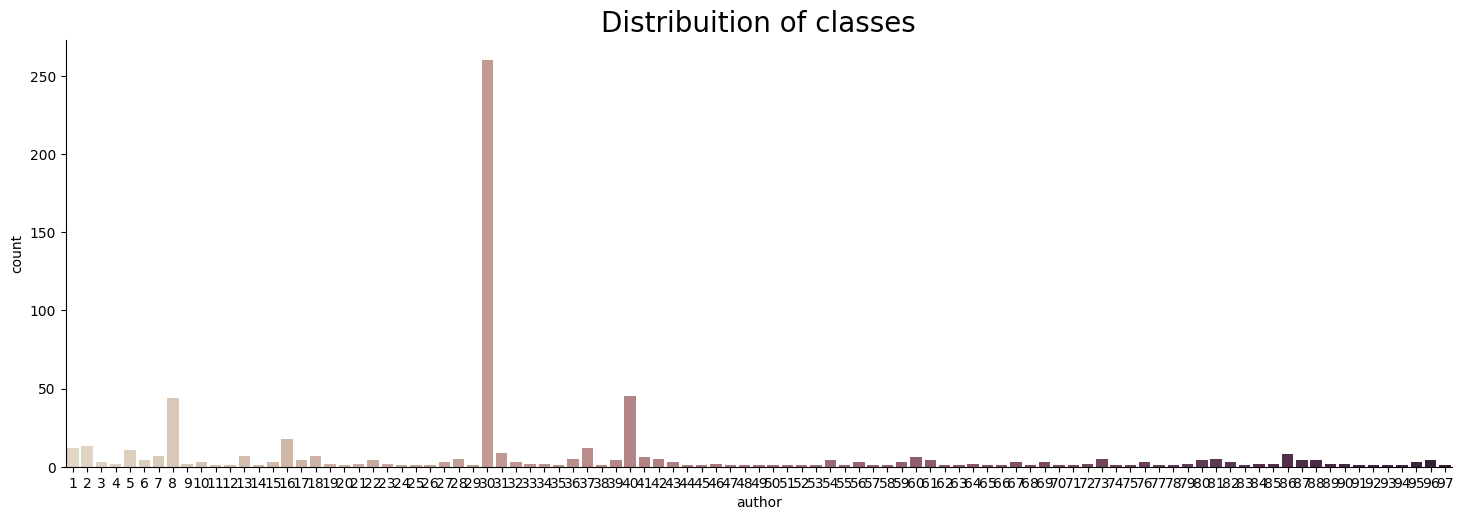

In [154]:
print(Counter(list(dataset['author'].values)))
g =sns.catplot(x="author", kind="count", palette="ch:.25", data=dataset)
g.fig.set_size_inches(17, 5)
g.ax.set_title('Distribuition of classes', fontsize=20)

In [155]:
prova = dataset.loc[1]
prova.text[:500]+"..."

'Effective 3 1 2001 HPLC amended its contract with Royal Production changing the price to 100 HSC less 0 16 and extending the term through 2 28 02 Consequently for March HPLC should be purhasing volumes from two wells at meter 5310 Effective April HPLC amended the same contract releasing the L G Talbert 2 lease in the committed reserves agreement Mike Morris is the gas buyer and expects volumes of approximately 2000mmbtu d For April I nom 1132 d Bob we should probably increase the nom to reflect ...'

# Preprocessing

In [156]:
dataset.isnull().sum()

text      0
author    0
dtype: int64

In [157]:
customized_list = ["â","a", "b", "c", "d", "e","f","g","h","l", "m", "n", "o", "p","q", "r", "s","t","u","v","w","z", "y", "j","k", "ah", "eh", "uh", "ahi", "oh", "ow", "ew", "aw"]
stopword_list = stopwords.words('english')+ list(string.punctuation) + customized_list

In [158]:
dataset_tokenized = dataset.copy()

for row in dataset_tokenized.itertuples():
    dataset_tokenized.at[row.Index, "text"]= word_tokenize(row.text)

for row in dataset_tokenized.itertuples():
    novel = [token for token in dataset_tokenized.at[row.Index, "text"] if token not in stopword_list]
    dataset_tokenized.at[row.Index, "text"]= novel

stemmer = SnowballStemmer(language='english')

for row in dataset_tokenized.itertuples():
    novel = [stemmer.stem(token) for token in row.text]
    dataset_tokenized.at[row.Index, "text"]= novel

#save tokenized dataset on drive
dataset_tokenized.to_pickle("../Data/data_tokenized.csv")

# Split in Test and Traning set

In [159]:
labels_list = dataset_tokenized["author"]
X_train, X_test, y_train, y_test = train_test_split(dataset_tokenized, labels_list, test_size=0.3, random_state=1)
X_train

,text,author
118,"[as, discuss, earlier, i, propos, ramp, late, ...",30
4,"[i, still, concern, april, nom, take, zero, co...",4
428,"[i, think, saturday, morn, come, strong, get, ...",30
531,"[ena, invoic, coral, energi, two, deal, teja, ...",16
530,"[i, see, new, path, desk, desk, nov, 2000, you...",16
...,...,...
129,"[x, to, capasso, joe, o, enron, ou, na, cn, re...",30
144,"[in, refer, eterra, i, priorit, enhanc, system...",36
72,"[this, deal, equistar, there, enough, gas, met...",21
235,"[this, mail, properti, enron, corp, relev, aff...",55


In [160]:
corpus_train = []
n_docs = len(X_train['text'])
for i in range(0, n_docs-1):
    corpus_train = corpus_train + X_train['text'].iloc[i]

In [161]:
# We concatenate all the texts of each author into a list of tokens and create a dictionary to hold the documents of each authortokens_authors = dict.fromkeys(authors_list,[])
for i in authors_list:
    docs_auth = [item[0] for item in X_train.loc[X_train.author == i].values]
    tokens_authors[i] =(docs_auth)
print(tokens_authors)

{1: [['x', 'to', 'robert', 'cotten', 'jacki', 'young', 'charlott', 'hawkin', 'carlo', 'j', 'rodriguez', 'stella', 'l', 'morri', 'aime', 'lannou', 'georg', 'grant', 'sabra', 'zajac', 'ricki', 'elli', 'tom', 'acton', 'mark', 'mccoy', 'eddi', 'janzen'], ['x', 'cc', 'gari', 'a', 'hank', 'angela', 'henn', 'howard', 'b', 'camp', 'lee', 'l', 'papayoti', 'daren', 'j', 'farmer', 'gari', 'w', 'lamphier', 'david', 'baumbach', 'lisa', 'csiko', 'joani', 'h', 'ngo', 'jennif', 'blay', 'pat', 'clyne'], ['x', 'cc', 'daren', 'j', 'farmer', 'daren', 'j', 'farmer', 'hou', 'ect', 'ect', 'edward', 'terri', 'edward', 'terri', 'hou', 'ect', 'ect', 'clem', 'cernosek', 'clem', 'cernosek', 'hou', 'ect', 'ect', 'juli', 'meyer', 'juli', 'meyer', 'hou', 'ect', 'ect', 'cynthia', 'hakemack', 'cynthia', 'hakemack', 'hou', 'ect', 'ect', 'melissa', 'grave', 'melissa', 'grave', 'hou', 'ect', 'ect', 'susan', 'smith', 'susan', 'smith', 'hou', 'ect', 'ect', 'donald', 'p', 'reinhardt', 'donald', 'p', 'reinhardt', 'hou', 'ect

In [162]:
#frequencies of terms used by each author
word_frequencies = dict.fromkeys(authors_list,[])

for author in authors_list:
    if (tokens_authors[author]):
        word_frequencies[author] = Counter(tokens_authors[author][0]).most_common()
    
    print(word_frequencies[author])

[('x', 1), ('to', 1), ('robert', 1), ('cotten', 1), ('jacki', 1), ('young', 1), ('charlott', 1), ('hawkin', 1), ('carlo', 1), ('j', 1), ('rodriguez', 1), ('stella', 1), ('l', 1), ('morri', 1), ('aime', 1), ('lannou', 1), ('georg', 1), ('grant', 1), ('sabra', 1), ('zajac', 1), ('ricki', 1), ('elli', 1), ('tom', 1), ('acton', 1), ('mark', 1), ('mccoy', 1), ('eddi', 1), ('janzen', 1)]
[('deal', 2), ('fyi', 1), ('creat', 1), ('submit', 1), ('commit', 1), ('reserv', 1), ('firm', 1), ('ticket', 1), ('remain', 1), ('term', 1), ('begin', 1), ('appropi', 1), ('month', 1), ('addit', 1), ('produc', 1), ('svcs', 1), ('track', 1), ('im', 1), ('wellhead', 1), ('portfolio', 1), ('attach', 1), ('gather', 1), ('contract', 1)]
[('duke', 2), ('mobil', 2), ('april', 2), ('flow', 2), ('i', 2), ('ticket', 2), ('sitara', 2), ('appar', 1), ('inadvert', 1), ('roll', 1), ('deliveri', 1), ('refineri', 1), ('gas', 1), ('via', 1), ('centana', 1), ('1', 1), ('2', 1), ('3', 1), ('understand', 1), ('enter', 1), ('cov

In [163]:
top_words_list = dict.fromkeys(authors_list,[])
for author in authors_list:
    if (word_frequencies[author]):
        list_tuples = word_frequencies[author][:10]
        top_words_list[author] = (list(list(zip(*list_tuples))[0]))
        
print(top_words_list)

{1: ['x', 'to', 'robert', 'cotten', 'jacki', 'young', 'charlott', 'hawkin', 'carlo', 'j'], 2: ['deal', 'fyi', 'creat', 'submit', 'commit', 'reserv', 'firm', 'ticket', 'remain', 'term'], 3: ['duke', 'mobil', 'april', 'flow', 'i', 'ticket', 'sitara', 'appar', 'inadvert', 'roll'], 4: ['april', 'i', 'still', 'concern', 'nom', 'take', 'zero', 'could', 'possibl', 'alloc'], 5: ['cn', 'enron', 'o', 'ou', 'na', 'recipi', 'neal', 'd', 'winfre', 'hou'], 6: ['rate', 'establish', 'end', 'the', 'transport', 'meter', 'compani', 'period', '2001', '9889'], 7: ['i', 'chang', 'highlght', 'spreadsheet', 'look', 'call', 'question', 'a', 'coupl', 'deal'], 8: ['purchas', 'price', 'fyi', 'anytim', 'done', 'industri', 'point', 'fix', 'kept', 'whole'], 9: ['deal', 'to', 'recap', 'talk', 'morn', 'the', 'follow', 'done', 'june', 'ena'], 10: ['daren', 'megan', 'gone', 'i', 'want', 'touch', 'base', 'status', 'enron', 'payment'], 11: ['at', '10', 'second', '2', 'min', 'left', '1st', 'quarter', 'neb', 'colo'], 12: ['

In [175]:
# Search for similar authors
authors_similars = []
for auth1 in authors_list:
    for auth2 in authors_list[::-1]:
        if auth1 != auth2:
            intersection = list(set(top_words_list[auth1]) & set(top_words_list[auth2]))
            if len(intersection) >= 2:
                authors_similars.append((auth1, auth2, intersection))
print(authors_similars)

[(1, 97, ['x', 'to']), (1, 95, ['j', 'x', 'to']), (1, 93, ['x', 'to']), (1, 84, ['j', 'robert', 'to']), (1, 82, ['x', 'to']), (1, 77, ['x', 'to']), (1, 73, ['j', 'x', 'to']), (1, 46, ['cotten', 'robert', 'x', 'to']), (1, 33, ['x', 'to']), (1, 31, ['x', 'to']), (2, 92, ['deal', 'term']), (2, 50, ['deal', 'ticket']), (3, 81, ['flow', 'i']), (3, 32, ['flow', 'i']), (3, 4, ['i', 'april']), (4, 32, ['take', 'i']), (4, 3, ['i', 'april']), (5, 97, ['cn', 'enron', 'na', 'recipi', 'ou', 'o']), (5, 85, ['enron', 'cn', 'na', 'hou', 'ou', 'recipi', 'o']), (5, 84, ['enron', 'hou']), (5, 77, ['cn', 'enron', 'na', 'recipi', 'ou', 'o']), (5, 55, ['enron', 'recipi']), (5, 45, ['cn', 'enron', 'na', 'recipi', 'ou', 'o']), (5, 33, ['cn', 'enron', 'na', 'recipi', 'ou', 'o']), (5, 31, ['cn', 'enron', 'na', 'recipi', 'ou', 'o']), (6, 94, ['the', 'meter']), (7, 89, ['question', 'call', 'i']), (7, 48, ['deal', 'question', 'i', 'look']), (7, 21, ['deal', 'i']), (7, 16, ['deal', 'i']), (7, 15, ['deal', 'i']), (8

In [176]:
lists_similar_authors = [[] for i in range(len(authors_list))] 
i = 0
for author in authors_list:
    l = [a_tuple[1] for a_tuple in authors_similars if a_tuple[0] == author] ## lista di autori simili per l'autore "author"
    if l: 
        lists_similar_authors[i] = [author] + [l]
    else:
        lists_similar_authors[i] = [author]
    i += 1

column_labels=[ "author","similar authors"]
df=pd.DataFrame(lists_similar_authors,columns=column_labels)
df[:]

,author,similar authors
0,1,"[97, 95, 93, 84, 82, 77, 73, 46, 33, 31]"
1,2,"[92, 50]"
2,3,"[81, 32, 4]"
3,4,"[32, 3]"
4,5,"[97, 85, 84, 77, 55, 45, 33, 31]"
...,...,...
92,93,"[97, 95, 82, 77, 73, 46, 33, 31, 26, 1]"
93,94,[6]
94,95,"[97, 93, 87, 85, 84, 82, 77, 73, 46, 33, 31, 2..."
95,96,None
